# Load Dependecies and Hubbard Brook Info File

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import hb_dic, fft_utils

In [ ]:
import json

with open("hbinfo.json", "r") as f:
    hbinfo = json.load(f)
del f

hbinfo

# Some Info about The Hubbard Brook Watershed

## Map

<div style="background-color: white;">
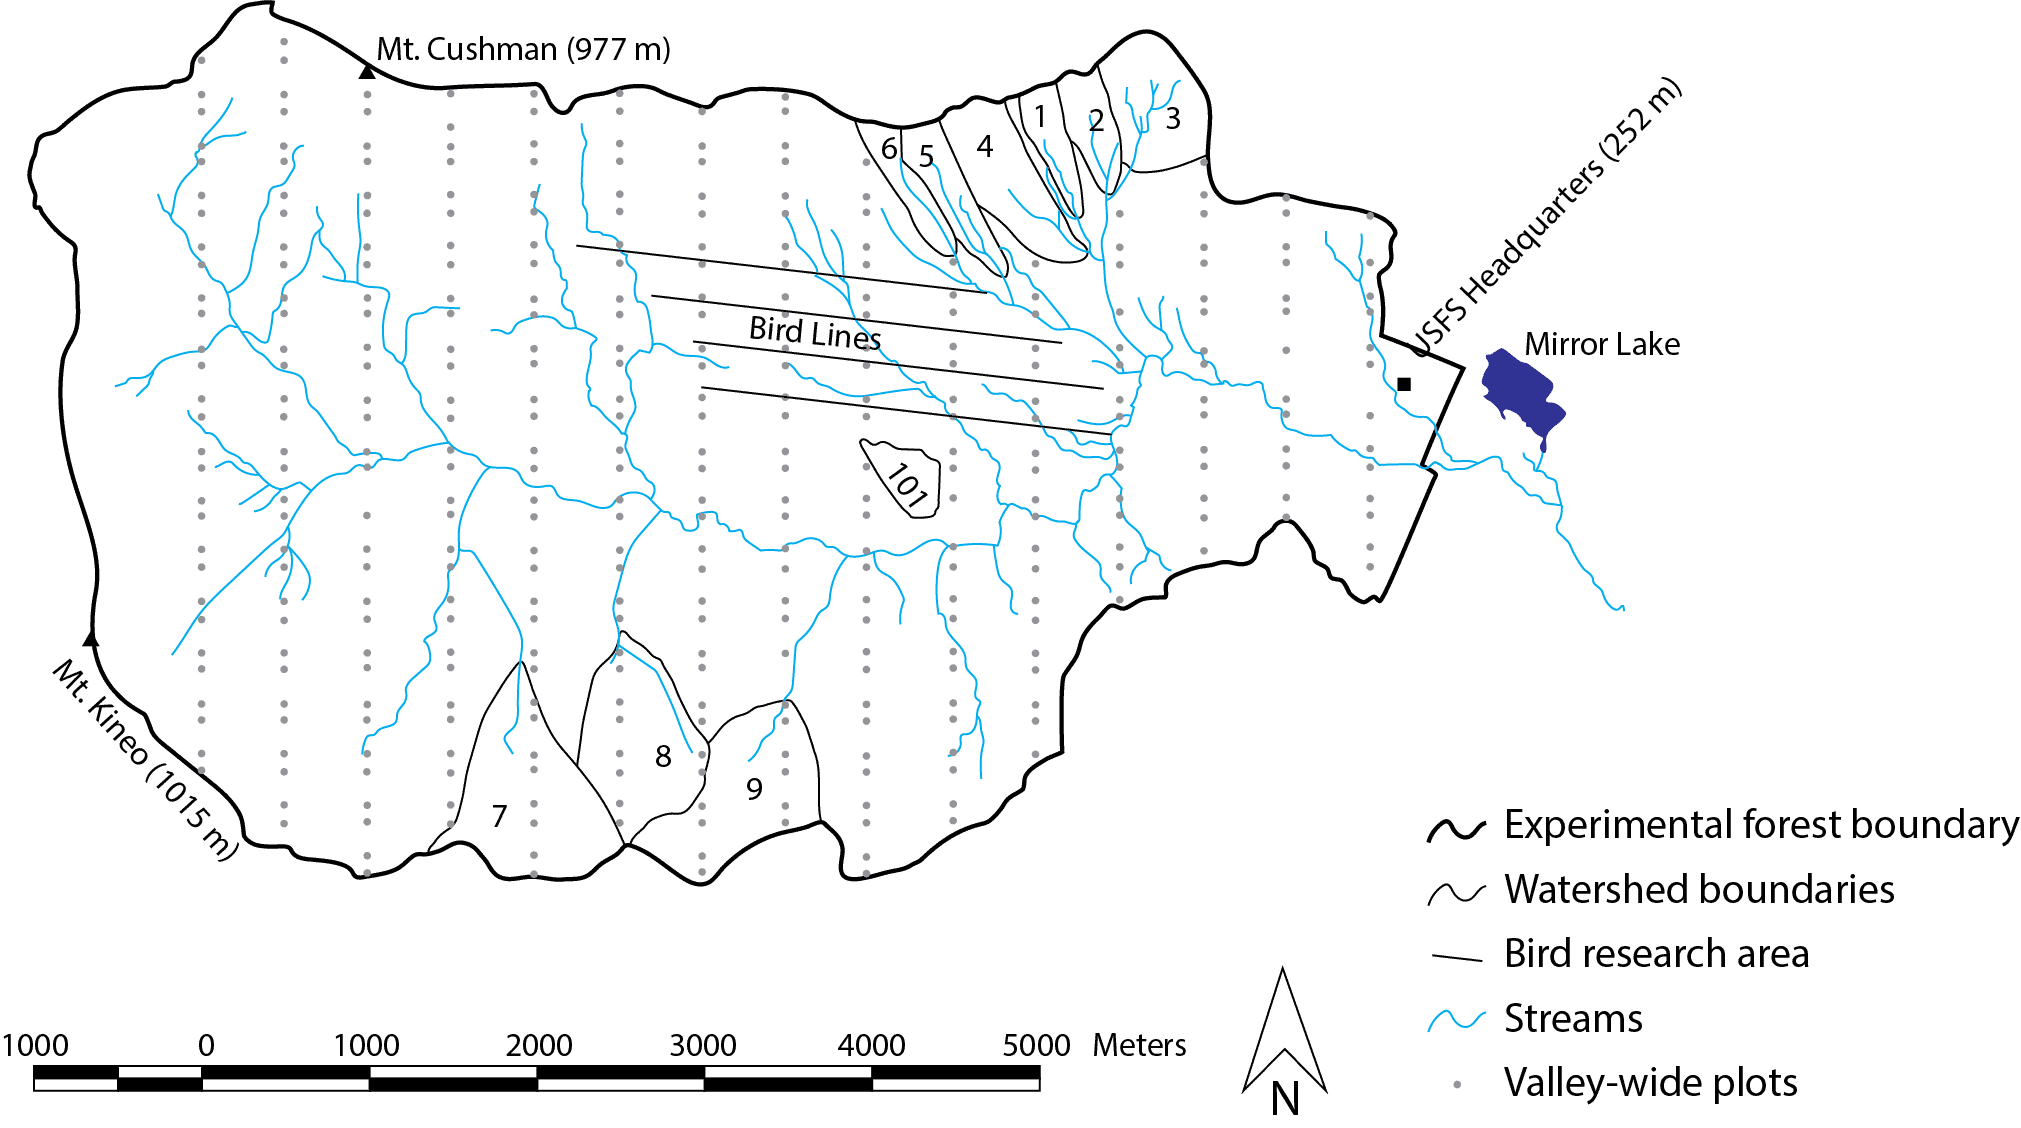
</div>

## DIC Data Availablility

Hubbard Brook weekly stream chemistry DIC data (Unit: mmol/L)

Data is available for W6 from 01/03/1994, and for other watersheds W1~W9 from 05/28/1996

Data for HBK is available in a monthly resolution from 06/17/1996, so does W101 but from 07/14/1997, and ML70 with a weekly resolution from 06/03/2013

# Single Watershed Analysis

## Preparations

### Load Data and Preprocessing

In [ ]:
watershed = hbinfo["biogeochem_ref_watershed"] #example watersed
DIC = hb_dic.load_DIC_series(watershed)

### Plot Params

In [ ]:
single_figure_kwargs = {
    "figsize": (10, 5),
}

## Plot Original Time Series

Blue line is the series, and red traiangles are NaN values.

In [ ]:
plt.figure(**single_figure_kwargs)
DIC_plot = hb_dic.SeriesPlotWithMissingValues()
DIC_plot.plot(DIC,
              ylabel=f"DIC ({hbinfo["data"]["DIC"]["unit"]})")

## Plot Resampled Weekly Time Series

Blue line is the series, and red traiangles are NaN values.

In [ ]:
DIC_resampled = fft_utils.weekly_resample(DIC)
plt.figure(**single_figure_kwargs)
DIC_resampled_plot = hb_dic.SeriesPlotWithMissingValues()
DIC_resampled_plot.plot(DIC_resampled,
                        ylabel=f"DIC ({hbinfo["data"]["DIC"]["unit"]})")
print(
    """
    Length of the series: {}
    Number of missing values: {}
    """.format(
        DIC_resampled_plot.n_data_, DIC_resampled_plot.n_missing_
    )
)

## Fourier Transformation

Fourier power spectrum, largest peak at about one year, which means the annual cycle is the dominant component.

In [ ]:
DIC_filled = DIC_resampled.interpolate()  # fill missing data
power_specturm = fft_utils.spectrum(DIC_filled)
plt.figure(**single_figure_kwargs)
power_specturm_plot = fft_utils.FourierSpectrumPlot()
power_specturm_plot.plot(power_specturm)

# Multiple Watershed Analysis

## Preparations

### Select Watersheds

In [ ]:
watershed_list = hbinfo["watersheds"]
n_watershed = len(watershed_list)

### Plot Params

In [ ]:
multi_figure_kwargs = {
    "nrows" : 3,
    "ncols" : 3,
    "figsize": (16, 12),
    "constrained_layout": True,
}
assert multi_figure_kwargs["nrows"] * multi_figure_kwargs["ncols"] == n_watershed

### Load Data and Save as Dicts

In [ ]:
data_dict = hb_dic.load_watershed_data(watershed_list, ["DIC", "pH"])

### Get Resampled DIC

In [ ]:
DIC_resampled_dict = {}
for watershed in watershed_list:
    DIC: pd.Series = data_dict[watershed]["DIC"]
    DIC_resampled_dict[watershed] = fft_utils.weekly_resample(DIC)

## pH Check

In [ ]:
pH_fig, pH_axs = plt.subplots(
    **multi_figure_kwargs,
    subplot_kw={"ylabel": "pH"}
)
for i in range(n_watershed):
    watershed = watershed_list[i]
    pH: pd.Series = data_dict[watershed]["pH"]

    plt.sca(pH_axs.flat[i])
    plt.ylim(3.8, 7.0)
    pH_plot = hb_dic.SeriesPlotWithMissingValues()
    pH_plot.plot(pH)

    pH_min, pH_max = pH.min(), pH.max()
    hline_fmt = {"color": "C2", "linestyle": "-."}
    plt.axhline(pH.min(), **hline_fmt)
    plt.axhline(pH.max(), **hline_fmt)

    plt.title(watershed)

## Resampled DIC Plot

### Plot DIC Profile

In [ ]:
DIC_fig, DIC_axs = plt.subplots(
    **multi_figure_kwargs,
    subplot_kw={"ylabel": f"DIC ({hbinfo["data"]["DIC"]["unit"]})"},
)

for i in range(n_watershed):
    watershed = watershed_list[i]
    DIC_resampled: pd.Series = DIC_resampled_dict[watershed]
    plt.sca(DIC_axs.flat[i])
    DIC_resampled_plot = hb_dic.SeriesPlotWithMissingValues()
    DIC_resampled_plot.plot(DIC_resampled)

    plt.title(watershed)

### Plot Missing Ratio of Resampled Data

In [ ]:
valid_num = []
missing_num = []

for i in range(n_watershed):
    watershed = watershed_list[i]
    DIC_resampled = DIC_resampled_dict[watershed]
    n_total = len(DIC_resampled)
    n_valid = DIC_resampled.count()
    n_missing = n_total - n_valid
    valid_num.append(n_valid)
    missing_num.append(n_missing)

bottom = np.zeros(n_watershed)
counts = {
    "missing": np.array(missing_num),
    "valid": np.array(valid_num),
}

plt.figure(figsize=(12, 8))

for validity, count in counts.items():
    plt.bar(watershed_list, count, 0.5, label=validity, bottom=bottom)
    bottom += count

plt.legend();

## Plot Fourier Spectra of DIC

In [ ]:
spec_fig, spec_axs = plt.subplots(
    **multi_figure_kwargs,
)

for i in range(n_watershed):
    watershed = watershed_list[i]
    DIC_filled = DIC_resampled_dict[watershed].interpolate()
    power_specturm = fft_utils.spectrum(DIC_filled)
    plt.sca(spec_axs.flat[i])
    power_specturm_plot = fft_utils.FourierSpectrumPlot()
    power_specturm_plot.plot(power_specturm)
    plt.title(watershed)